## 1. Imports

**FinanceDataReader 패키지를 활용해 SP500의 주식 데이터를 수집**  
SP500의 구성종목 중 2013-01-01~ 2023-01-31에 결측치가 존재하지 않는 주식에 대해 데이터를 수집  
이후의 결과 비교를 위해 SP500지수를 benchmark로 설정

In [1]:
import FinanceDataReader as fdr
import pickle

import mybacktest as backtest # 자체 제작한 모듈

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from datetime import datetime
from time import time
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
start_date = "2013-01-01"
end_date = "2023-01-31"

In [3]:
benchmark = fdr.DataReader("US500", "2013-01-01", "2023-01-31")
benchmark = benchmark['Adj Close']
benchmark

Date
2013-01-02    1462.420044
2013-01-03    1459.369995
2013-01-04    1466.469971
2013-01-07    1461.890015
2013-01-08    1457.150024
                 ...     
2023-01-24    4016.949951
2023-01-25    4016.219971
2023-01-26    4060.429932
2023-01-27    4070.560059
2023-01-30    4017.770020
Name: Adj Close, Length: 2537, dtype: float64

In [4]:
sp500 = pd.read_csv('data/sp500.csv', index_col=0)
sp500.index = pd.to_datetime(sp500.index, format = "%Y-%m-%d")
sp500.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,68.910484,13.831623,26.270302,22.895281,57.066193,10.133719,21.668747,38.340000,40.810844,66.654129,...,18.928724,75.177574,172.004929,96.061661,19.723278,23.984154,39.681404,40.959999,60.438889,18.007874
2013-01-03,68.830513,13.615402,27.270285,22.706224,56.859608,10.189247,21.494911,37.750000,40.971615,66.654129,...,18.784111,75.945602,171.458481,97.094917,19.665646,23.905657,39.929573,41.000000,61.304848,18.032446
2013-01-04,69.339470,13.763116,27.106354,22.419382,57.173618,10.337319,22.084427,38.130001,41.335064,67.693153,...,18.989914,75.923622,172.576324,98.266502,19.737686,23.870773,40.366798,40.669998,61.617310,18.548359
2013-01-07,69.426735,13.611119,27.327662,22.465015,56.925716,10.346575,21.169909,37.939999,41.174297,67.463303,...,18.906479,75.704216,171.499863,98.600075,19.528786,23.556799,40.112728,40.900002,61.769085,18.458282
2013-01-08,69.433960,13.870156,27.335859,21.976084,57.256248,10.170738,21.419329,38.139999,41.411934,66.359901,...,18.672855,75.331192,168.634964,98.518715,19.564804,23.268984,38.428806,40.930000,61.858360,18.089766


In [5]:
tickers = sp500.columns.tolist()

## 2. 전략 수립 및 검증

### 2-1 개요

##### **LOW VOL 팩터는 변동성이 낮은 주식이 변동성이 높은 주식을 Outperorm함을 의미**    
변동성이 낮은 주식을 매수, 높은 주식을 매도하는 방식으로 포트폴리오를 설계,그 결과를 검증   
변동성은 수익률의 n일 이동 표준편차로 계산함  
우선, 2014-01-01~ 2021-01-01까지의 기간을 대상으로 전략을 수립, 그 결과를 검증  
(팩터를 산출하기 위해서 과거의 데이터까지 가져옴)
###### **만약, 결과가 안 좋을 시 다른 방식으로 전략을 수정**  

**cf) 백테스트 방식**  
각 날짜별로 보유 비중을 정하고, 해당 기간동안 각 자산을 전체자산 대비 정해진 비중만큼 매수 또는 매도.  
즉, 각 자산을(전체자산(현금+보유주식)* 비중) 매수 또는 매도(소수점 이하 버림).이 때, 현금에 대해서는  
매일 이자가 붙고, 매수/매도 시에는 수수료(commission)을, 매도시에는 세금(tax)를 추가로 납부.  
자세한 내용은 mybacktest 코드 참조  

In [6]:
start, end = "2013-01-01", "2021-01-01"

In [7]:
price_df = sp500[(sp500.index >= start) & (sp500.index <= end)]
price_df.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,68.910484,13.831623,26.270302,22.895281,57.066193,10.133719,21.668747,38.340000,40.810844,66.654129,...,18.928724,75.177574,172.004929,96.061661,19.723278,23.984154,39.681404,40.959999,60.438889,18.007874
2013-01-03,68.830513,13.615402,27.270285,22.706224,56.859608,10.189247,21.494911,37.750000,40.971615,66.654129,...,18.784111,75.945602,171.458481,97.094917,19.665646,23.905657,39.929573,41.000000,61.304848,18.032446
2013-01-04,69.339470,13.763116,27.106354,22.419382,57.173618,10.337319,22.084427,38.130001,41.335064,67.693153,...,18.989914,75.923622,172.576324,98.266502,19.737686,23.870773,40.366798,40.669998,61.617310,18.548359
2013-01-07,69.426735,13.611119,27.327662,22.465015,56.925716,10.346575,21.169909,37.939999,41.174297,67.463303,...,18.906479,75.704216,171.499863,98.600075,19.528786,23.556799,40.112728,40.900002,61.769085,18.458282
2013-01-08,69.433960,13.870156,27.335859,21.976084,57.256248,10.170738,21.419329,38.139999,41.411934,66.359901,...,18.672855,75.331192,168.634964,98.518715,19.564804,23.268984,38.428806,40.930000,61.858360,18.089766


### 2-2 전략 수립 및 검증(1) - 20일 LowVol(Long-Short)

##### **최근 20일 변동성이 낮은 100개 매수, 높은 100개 매도**    
최근 20일 변동성에 -1을 곱한 것에 상위 100개 매수, 하위 100개 매도(변동성은 음의 값 없음)  
(팩터 5분위가 변동성이 가장 낮은 주식, 1분위가 변동성이 가장 높은 주식)  
투자금액은 1,000,000달러로 설정  
각 매수/매도하는 자산의 비중은 1/100로 정함  
거래비용은 수수료 0.015% (매수, 매도 시 모두 부여), 증권거래세 0.2% (매도 시에만 부여)  
이자율은 연 3%를 1일 단위로 바꾼 것으로 설정($(1+0.03)^{(1/252)}-1 $)  
리밸런싱 주기는 20영업일로 설정(20영업일 마다 비중 재조정)

##### **해당 기간의 누적수익률은 -53.67%로 좋지 않은 수익률을 보임(연간 -10.41%)**   
##### **해당기간의 벤치마크(SP500) 누적수익률은 103.21%(연간 10.67%)**    
test_factor를 활용해 각 분위별 Long Only Portfolio의 성과를 비교해 본 결과,  
1분위 Long-Only Portfolio가 가장 좋은 수익률을 보였고, 분위가 높아질수록 수익률이 떨어지는 경향을 보임    
(변동성이 높을수록 수익률이 높은 것은 당연한 결과)  
샤프비율을 기준으로 봤을 때는 3,4,5 분위 포트폴리오가 오히려 성과가 더 좋은 것을 확인  

In [8]:
commission = 0.00015
tax = 0.002
interest = (1+0.03) ** (1/252) - 1
money = 1e6
start = "2014-01-01"

In [9]:
factor_df = price_df.pct_change().dropna().rolling(window=20).std().mul(-1)
factor_df = factor_df[(factor_df.index >= start) & (factor_df.index <= end)]
factor_df.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,-0.011319,-0.010292,-0.012287,-0.013642,-0.014957,-0.014681,-0.014791,-0.032440,-0.009056,-0.014478,...,-0.015020,-0.006479,-0.009807,-0.011566,-0.008499,-0.009717,-0.010679,-0.012749,-0.008827,-0.013064
2014-01-03,-0.011257,-0.010165,-0.012348,-0.013534,-0.014481,-0.014795,-0.014487,-0.032392,-0.008853,-0.015269,...,-0.014952,-0.006612,-0.009805,-0.011568,-0.008454,-0.009877,-0.010778,-0.012396,-0.008706,-0.012845
2014-01-06,-0.011497,-0.010033,-0.012169,-0.016127,-0.014740,-0.013456,-0.014363,-0.032377,-0.008945,-0.015365,...,-0.014567,-0.006303,-0.009926,-0.011243,-0.008501,-0.009823,-0.010035,-0.012038,-0.008757,-0.012937
2014-01-07,-0.011287,-0.010022,-0.011955,-0.014373,-0.014787,-0.012717,-0.014441,-0.032443,-0.008784,-0.015395,...,-0.014756,-0.005996,-0.009797,-0.012270,-0.008792,-0.009599,-0.010457,-0.011640,-0.009017,-0.012191
2014-01-08,-0.011521,-0.010324,-0.011787,-0.014372,-0.014645,-0.012711,-0.014427,-0.032428,-0.008649,-0.015567,...,-0.014354,-0.005992,-0.009812,-0.011312,-0.008582,-0.009597,-0.010451,-0.011593,-0.010343,-0.012329


In [10]:
rebalance_period=20
rebalance_dates = factor_df.index[::rebalance_period].tolist()

In [11]:
signal = backtest.generate_signal_using_factor(factor_df, n_positions=100,
                                               long_min=-np.inf, short_max=np.inf, long_short=True)

In [12]:
weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=100,
                                                              n_min_positions=0, long_short=True)

In [13]:
daily_return= backtest.backtest_from_weights(price_df, weights, money,
                                            rebalance_dates, commission, tax, interest)

In [14]:
cumulative_return = backtest.calculate_cumulative_return(daily_return)
cumulative_return

2014-01-02   -0.002176
2014-01-03   -0.003969
2014-01-06   -0.001709
2014-01-07   -0.001889
2014-01-08   -0.008831
                ...   
2020-12-24   -0.534900
2020-12-28   -0.535695
2020-12-29   -0.534195
2020-12-30   -0.539788
2020-12-31   -0.536657
Length: 1763, dtype: float64

In [15]:
benchmark_return = benchmark.pct_change().dropna()
benchmark_return = benchmark_return[(benchmark_return.index >= daily_return.index[0]) & 
                            (benchmark_return.index <= daily_return.index[-1])]

In [16]:
benchmark_cumulative_return = backtest.calculate_cumulative_return(benchmark_return)
benchmark_cumulative_return

Date
2014-01-02   -0.008862
2014-01-03   -0.009192
2014-01-06   -0.011681
2014-01-07   -0.005670
2014-01-08   -0.005881
                ...   
2020-12-24    1.003430
2020-12-28    1.020905
2020-12-29    1.016404
2020-12-30    1.019109
2020-12-31    1.032110
Name: Adj Close, Length: 1763, dtype: float64

In [17]:
summary_stats = backtest.summary_stats(daily_return,rf=0, alpha=0.05, min_return=0, year=252, benchmark=benchmark_return)
summary_stats

,Portfolio,Benchmark
Cumulative Return,-53.67%,103.21%
Annualized Return,-10.41%,10.67%
Annualized Std,18.37%,17.80%
Annualized Sharpe,-50.61%,65.91%
MDD,-61.93%,-33.92%
Var,-40.63%,-18.61%
C_Var,-48.30%,-26.05%
Shortfall Prob(min_return=0.00%),71.46%,27.45%


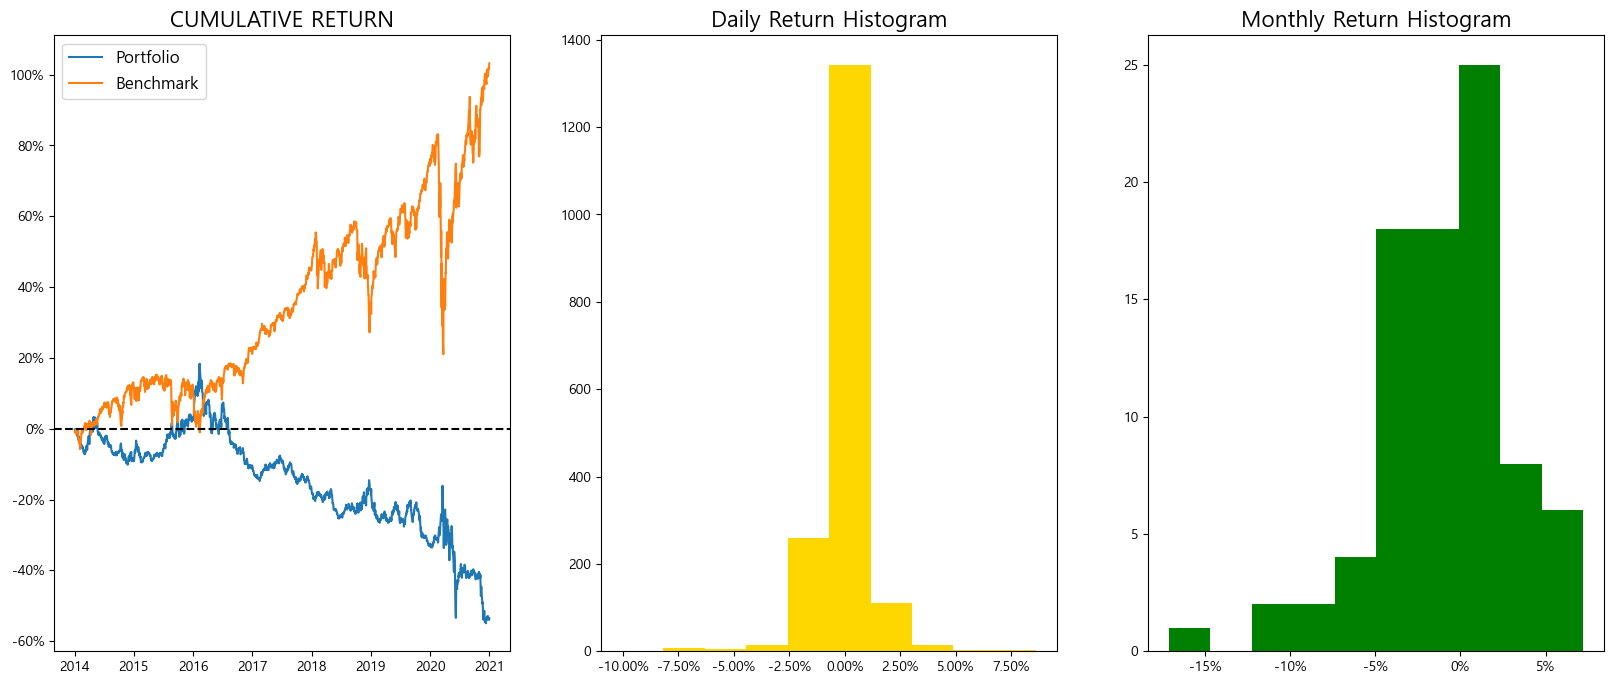

In [18]:
backtest.plot_return(daily_return, benchmark_return)

In [19]:
factor_test = backtest.test_factor(5, price_df, factor_df, money, rebalance_dates, 
                                   commission, interest, tax)
factor_test

,Q1,Q2,Q3,Q4,Q5
Annualized_return,0.216104,0.141407,0.159601,0.144397,0.127570
Annualized_std,0.269176,0.215106,0.188577,0.172101,0.154403
Annualized_sharpe,0.861544,0.722761,0.880033,0.870440,0.855551
MDD,-0.449120,-0.417015,-0.374898,-0.375112,-0.342637


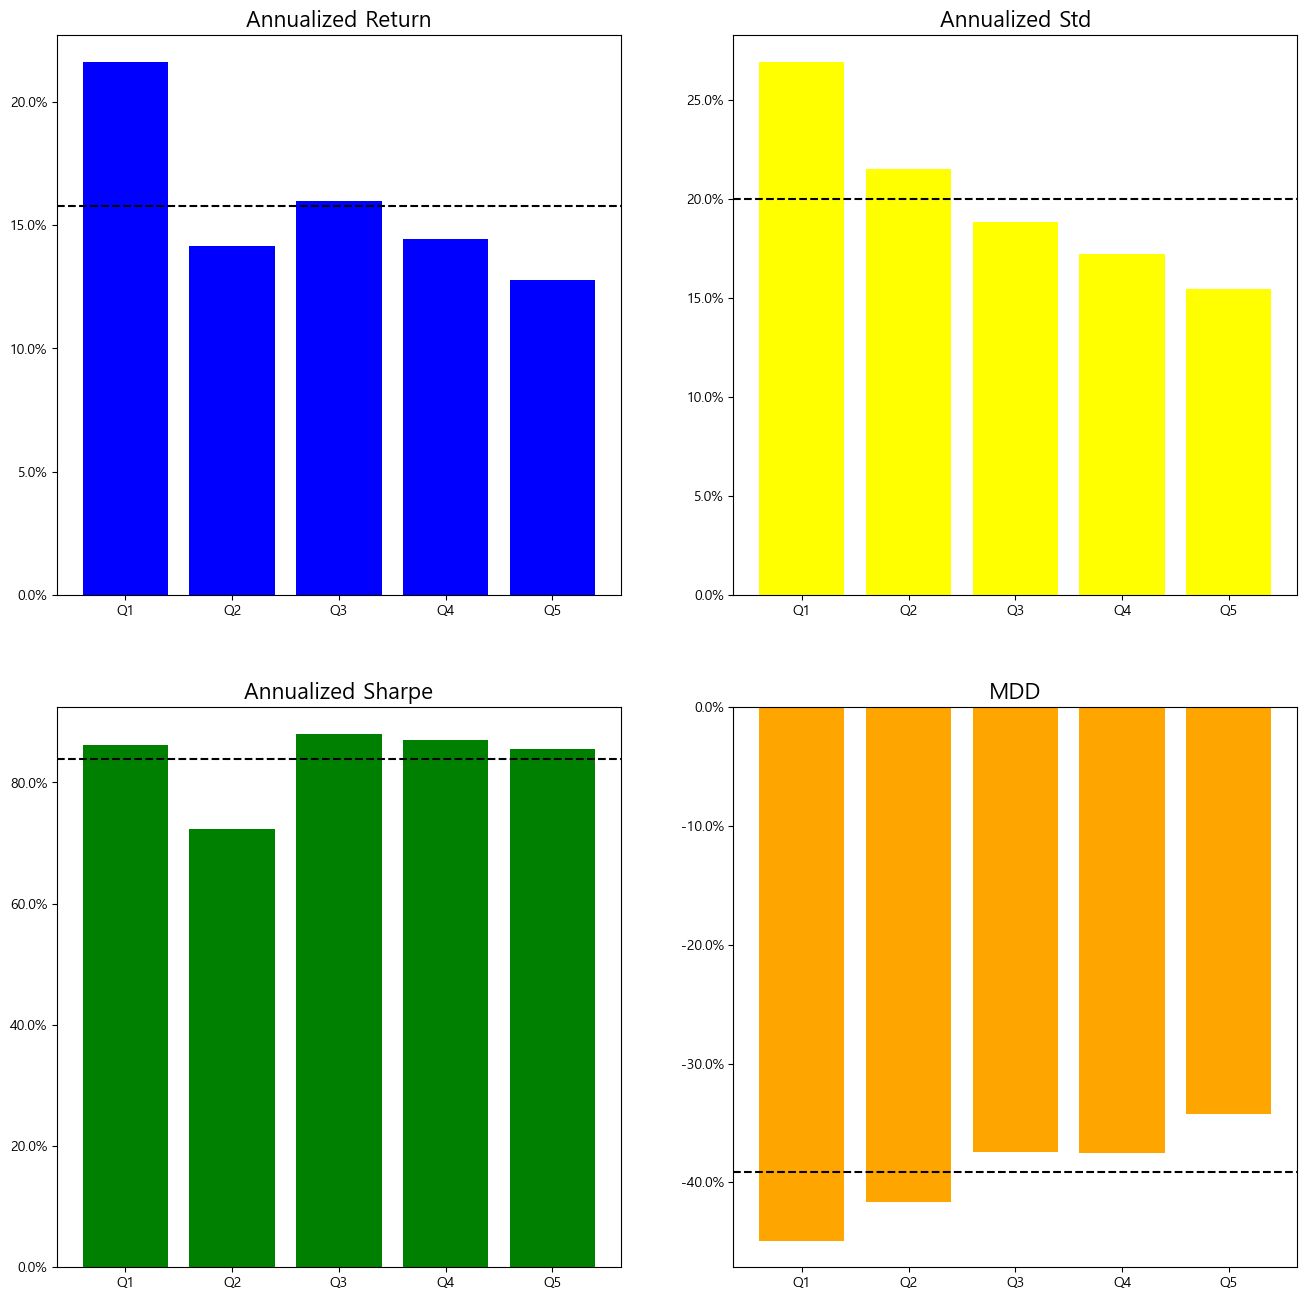

In [20]:
backtest.plot_factor_test_result(5, price_df, factor_df, money, rebalance_dates, commission,
                                interest, tax)

### 2-3 전략 수립 및 검증(2) - 20일 역모멘텀 전략(Long Only)

##### 2-2의 결과를 통해 모든 분위의 포트폴리오가 양의 수익률을 보이고 있는 것을 확인  
##### Long-Short보다는 Long-Only를 하는 것이 더 나은 수익률을 가져올 수도 있을 것으로 분석

##### **변동성이 낮은 하위 100개 매수**    
매수하는 자산의 비중은 1/100로 정함  
투자금액, 세금, 이자율, 수수료 등은 이전과 동일하다고 가정  
리밸런싱 주기는 20일로 설정  

##### **해당 기간의 누적수익률은 111.60%의 수익률을 보임(연간 11.31%)**    
##### **해당기간의 벤치마크(SP500) 누적수익률은 103.21%(연간 10.67%)**      
Long Only포트폴리오가 더 낮은 변동성을 지님과 동시에 더 높은 수익률을 기록함  
즉, 해당 기간에서 안정적으로 더 높은 수익을 냄을 의미  

In [21]:
factor_df = price_df.pct_change().dropna().rolling(window=20).std().mul(-1)
factor_df = factor_df[(factor_df.index >= start) & (factor_df.index <= end)]
rebalance_period=20
rebalance_dates = factor_df.index[::rebalance_period].tolist()
signal = backtest.generate_signal_using_factor(factor_df, n_positions=100,
                                               long_min=-np.inf, short_max=np.inf, long_short=False)
weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=100,
                                                              n_min_positions=0, long_short=False)
daily_return= backtest.backtest_from_weights(price_df, weights, money,
                                            rebalance_dates, commission, tax, interest)

In [22]:
summary_stats = backtest.summary_stats(daily_return,benchmark=benchmark_return)
summary_stats

,Portfolio,Benchmark
Cumulative Return,111.60%,103.21%
Annualized Return,11.31%,10.67%
Annualized Std,15.43%,17.80%
Annualized Sharpe,77.22%,65.91%
MDD,-34.43%,-33.92%
Var,-14.07%,-18.61%
C_Var,-20.52%,-26.05%
Shortfall Prob(min_return=0.00%),23.18%,27.45%


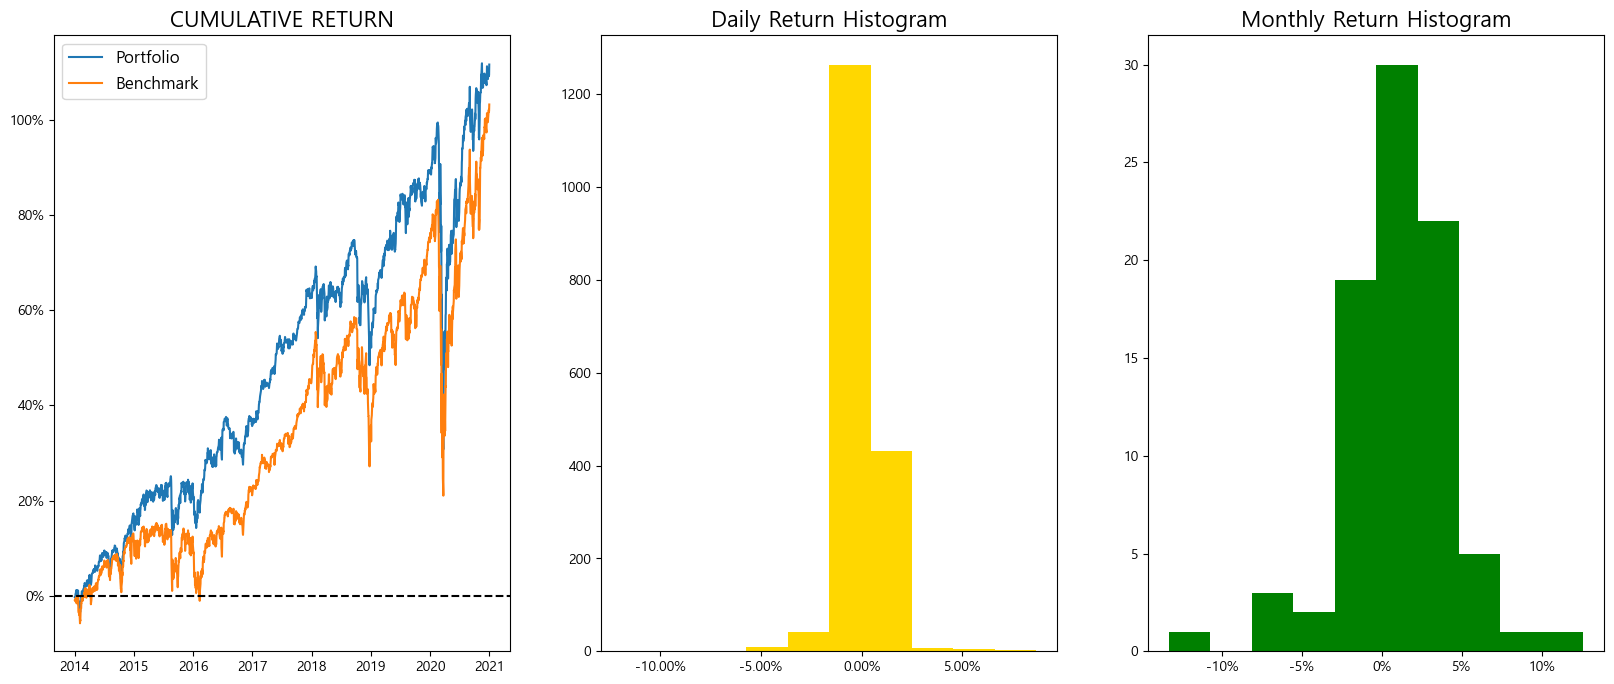

In [23]:
backtest.plot_return(daily_return, benchmark=benchmark_return)

In [24]:
factor_test = backtest.test_factor(5, price_df, factor_df, 1e6,rebalance_dates, 
                                   commission, interest, tax)
factor_test

,Q1,Q2,Q3,Q4,Q5
Annualized_return,0.216104,0.141407,0.159601,0.144397,0.127570
Annualized_std,0.269176,0.215106,0.188577,0.172101,0.154403
Annualized_sharpe,0.861544,0.722761,0.880033,0.870440,0.855551
MDD,-0.449120,-0.417015,-0.374898,-0.375112,-0.342637


## 3. 전략 최적화 및 추가 분석

### 3-1 전략 최적화

##### 2-3의 전략을 수정해서 보다 더 좋은 성과를 내는 전략을 찾고자 함    
20일, 60일, 120일, 180일, 250일 등을 기준으로 변동성 팩터를 산출하고, 리밸런싱 주기도  20일, 40일,  60일, 80일, 100일 등으로 변경    
샤프비율을 기준으로 순위를 매겨 봄   
전체적인 방식은 2-3과 동일

##### 다양한 전략들을 샤프비율을 기준으로 테스트해본 결과, 
##### 180일 변동성팩터, 20일  단위로 리밸런싱

In [27]:
commission = 0.00015
tax = 0.002
interest = (1+0.03) ** (1/252) - 1
money = 1e6
start = "2014-01-01"

window_length = [20, 60, 120, 180, 250]
rebalance_periods = [20, 40, 60, 80, 100]
result_df = []
for window in window_length:
    for rebalance_period in rebalance_periods:
        factor_df = price_df.pct_change().dropna().rolling(window=window).std().mul(-1)
        factor_df = factor_df[(factor_df.index >= start) & (factor_df.index <= end)]
        signal = backtest.generate_signal_using_factor(factor_df, n_positions=100,
                                           long_min=-np.inf, short_max=np.inf, long_short=False)
        rebalance_dates = factor_df.index[::rebalance_period].tolist()
        weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=100,
                                                                        n_min_positions=0, long_short=False)
        daily_return = backtest.backtest_from_weights(price_df, weights, money,
                                    rebalance_dates, commission, tax, interest)
        annualized_return = backtest.annualize_return(daily_return)
        annualized_sharpe = backtest.annualize_sharpe(daily_return)
        result_df.append([window, rebalance_period, annualized_return, annualized_sharpe])
opt_df = pd.DataFrame(result_df, columns=['window', 'rebalance_period',
                                          'annualized_return', 'annualized_sharpe'])
opt_df = opt_df.sort_values(by='annualized_sharpe', ascending=False)
opt_df = opt_df.reset_index(drop=True)
opt_df.head(10)

,window,rebalance_period,annualized_return,annualized_sharpe
0,180,20,0.135474,0.897989
1,250,20,0.133066,0.876622
2,120,20,0.131599,0.876252
3,60,20,0.129766,0.873910
4,60,100,0.132314,0.871705
5,180,60,0.131046,0.861176
6,120,40,0.128528,0.859417
7,180,40,0.129835,0.858352
8,20,60,0.129342,0.853351
9,120,60,0.128025,0.850578


##### 180일 변동성팩터, 20일  단위로 리밸런싱, 동일가중방식

In [28]:
window = 180
rebalance_period=20
factor_df = price_df.pct_change().dropna().rolling(window=window).std().mul(-1)
factor_df = factor_df[(factor_df.index >= start) & (factor_df.index <= end)]
rebalance_period=rebalance_period
rebalance_dates = factor_df.index[::rebalance_period].tolist()
signal = backtest.generate_signal_using_factor(factor_df, n_positions=100,
                                               long_min=-np.inf, short_max=np.inf, long_short=False)
weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=100,
                                                              n_min_positions=0, long_short=False)
daily_return= backtest.backtest_from_weights(price_df, weights, money,
                                            rebalance_dates, commission, tax, interest)

In [29]:
summary_stats = backtest.summary_stats(daily_return,rf=0, alpha=0.05, min_return=0, year=252, benchmark=benchmark_return)
summary_stats

,Portfolio,Benchmark
Cumulative Return,143.23%,103.21%
Annualized Return,13.55%,10.67%
Annualized Std,15.50%,17.80%
Annualized Sharpe,89.80%,65.91%
MDD,-35.79%,-33.92%
Var,-11.94%,-18.61%
C_Var,-18.42%,-26.05%
Shortfall Prob(min_return=0.00%),19.10%,27.45%


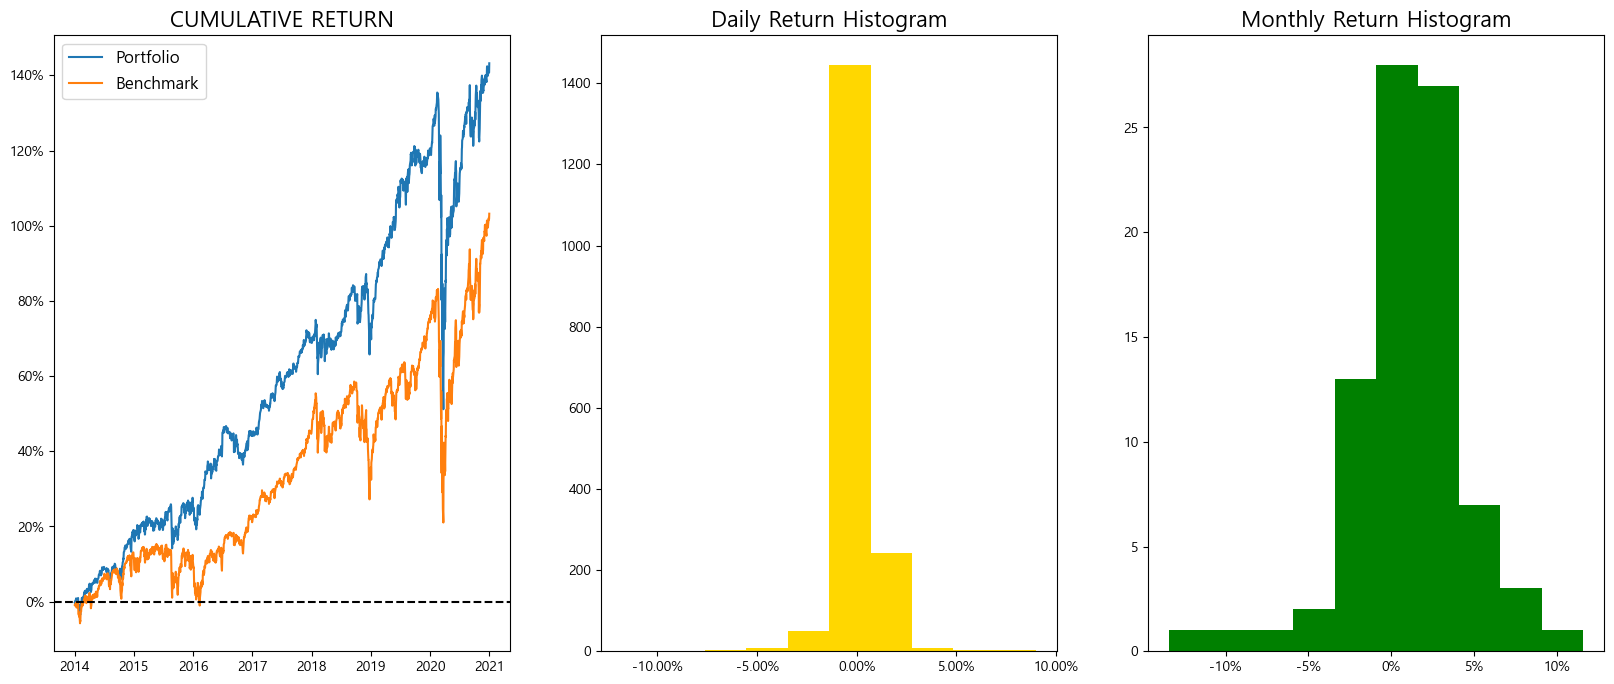

In [30]:
backtest.plot_return(daily_return, benchmark=benchmark_return)

### 3-2 추가분석

#####  Pyfolio, Quantstats 등의 Package를 활용해 보다 추가적인 분석을 진행하기로 함

In [31]:
import pyfolio as pf
import quantstats as qs
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe

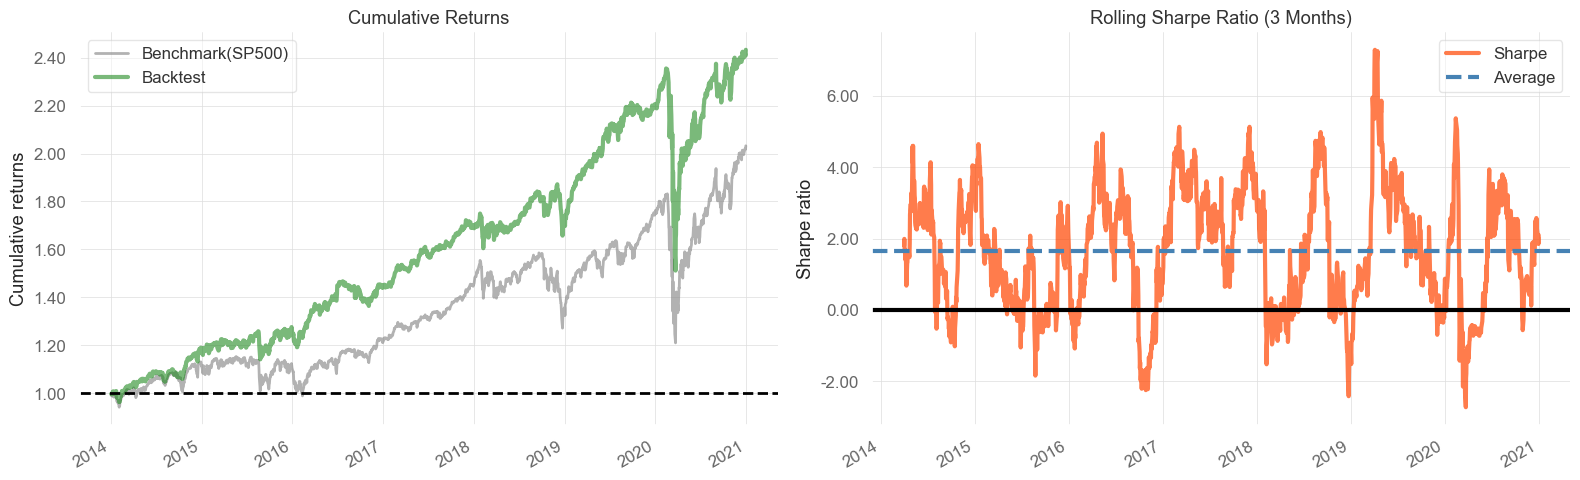

In [32]:
benchmark_return.name='Benchmark(SP500)'
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(daily_return,
                     factor_returns=benchmark_return,
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout()

Start date,2014-01-02
End date,2020-12-31
Total months,83
,Backtest
Annual return,13.547%
Cumulative returns,143.232%
Annual volatility,15.496%
Sharpe ratio,0.90
Calmar ratio,0.38
Stability,0.97
Max drawdown,-35.786%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.79,2020-02-14,2020-03-23,2020-09-02,144
1,11.44,2018-12-03,2018-12-24,2019-02-12,52
2,9.31,2015-08-17,2015-08-25,2015-11-02,56
3,8.26,2018-01-26,2018-02-08,2018-07-12,120
4,7.00,2016-07-22,2016-11-04,2017-02-09,145


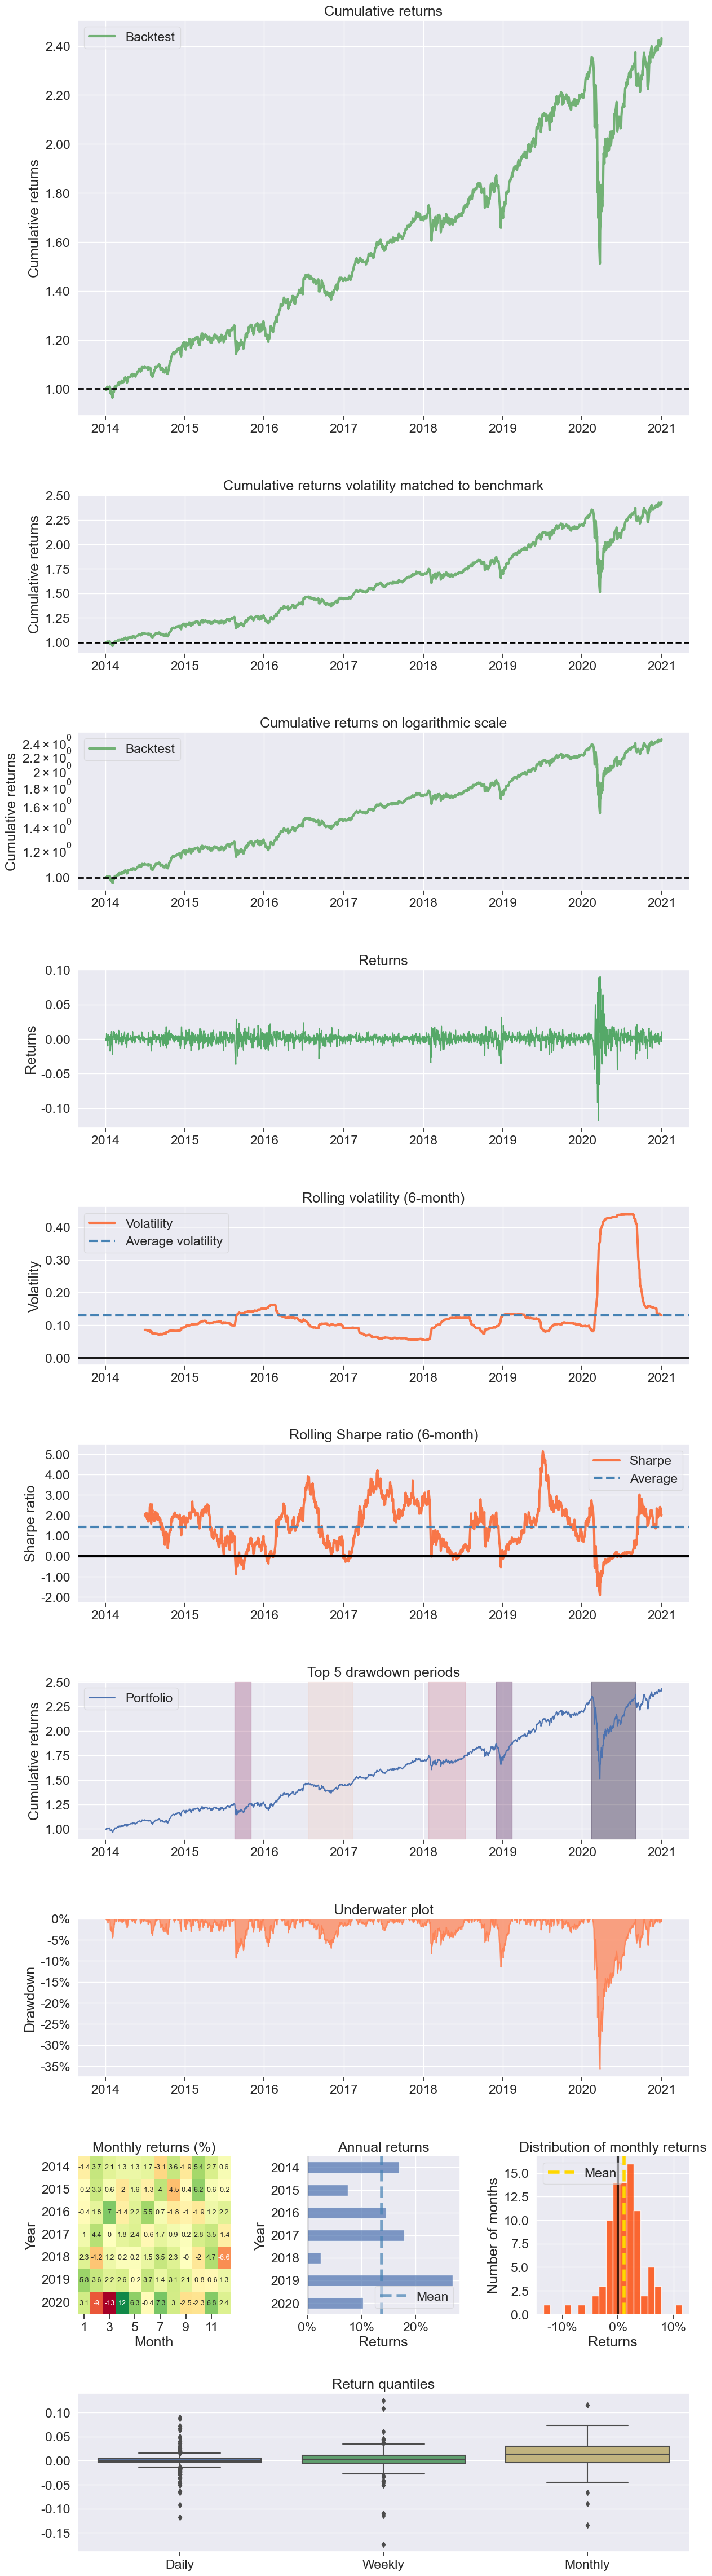

In [33]:
pf.create_returns_tear_sheet(daily_return)

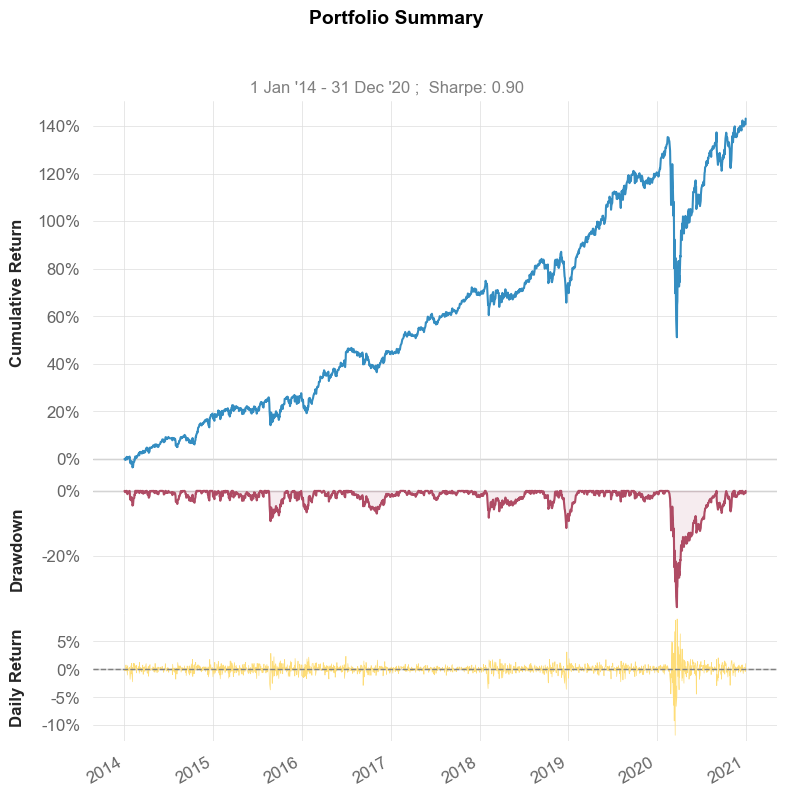

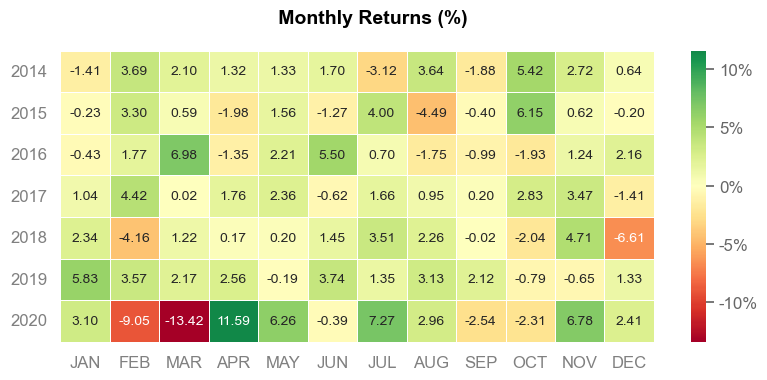

In [34]:
qs.reports.plots(daily_return, mode='basic')

In [35]:
qs.reports.metrics(daily_return, benchmark=benchmark_return, mode='basic')

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2014-01-02  2014-01-02
End Period          2020-12-31  2020-12-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   143.23%     103.21%
CAGR﹪              13.54%      10.66%

Sharpe              0.9         0.66
Prob. Sharpe Ratio  98.92%      95.65%
Sortino             1.25        0.91
Sortino/√2          0.89        0.64
Omega               1.22        1.22

Max Drawdown        -35.79%     -33.92%
Longest DD Days     199         416

Gain/Pain Ratio     0.22        0.15
Gain/Pain (1M)      1.58        0.95

Payoff Ratio        0.9         0.85
Profit Factor       1.22        1.15
Common Sense Ratio  1.23        1.02
CPC Index           0.63        0.54
Tail Ratio          1.01        0.89
Outlier Win Ratio   4.34        3.55
Outlier Loss Ratio  4.99        4.22

MTD                 2.41%       3.71%
3M                  7.52%       12

### 3-3 다른 기간에 대한 검증

##### 2021-01-01~2023-01-30까지의 기간에 대해 해당전략을 적용하고, 성과를 평가

##### **해당 기간의 누적수익률은 19.43%로 좋은 수익률을 보임(연간 8.95%)**    
##### **해당기간의 벤치마크(SP500) 누적수익률은 6.97%(연간 3.31%)**      
##### **벤치마크에 비해 낮은 변동성과 높은 수익률을 기록함. 이 전략은 유효하다고 할 수 있다.**
##### **다만 이 경우에는 변동성이 가장 높은 주식(1분위)들이 훨씬 더 높은 수익률을 기록함으로써 샤프비율에서도 앞서는 결과를 가져왔다.**  

In [36]:
start, end = "2021-01-01", "2023-01-30"

factor_df = sp500.pct_change().dropna().rolling(window=180).std().mul(-1)
factor_df = factor_df[(factor_df.index >= start) & (factor_df.index <= end)]

price_df = sp500[(sp500.index >= start) & (sp500.index <= end)]

In [37]:
benchmark_return = benchmark.pct_change().dropna()
benchmark_return = benchmark_return[(benchmark_return.index >= start) & (benchmark_return.index <= end)]

In [38]:
rebalance_period = 20
rebalance_dates = factor_df.index[::rebalance_period].tolist()
signal = backtest.generate_signal_using_factor(factor_df, n_positions=100,
                                               long_min=-np.inf, short_max=np.inf, long_short=False)
weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=100,
                                                              n_min_positions=0, long_short=False)
daily_return= backtest.backtest_from_weights(price_df, weights, money,
                                            rebalance_dates, commission, tax, interest)

In [39]:
factor_test = backtest.test_factor(5, price_df, factor_df, money, rebalance_dates, 
                                   commission, interest, tax)
factor_test

,Q1,Q2,Q3,Q4,Q5
Annualized_return,0.210630,0.147180,0.080434,0.100095,0.100650
Annualized_std,0.284265,0.218872,0.187177,0.162467,0.140252
Annualized_sharpe,0.814609,0.736666,0.506755,0.668424,0.753956
MDD,-0.242539,-0.237100,-0.226334,-0.184698,-0.167792


In [40]:
summary_stats = backtest.summary_stats(daily_return,rf=0, alpha=0.05, min_return=0, year=252, benchmark=benchmark_return)
summary_stats

,Portfolio,Benchmark
Cumulative Return,19.43%,6.97%
Annualized Return,8.95%,3.31%
Annualized Std,13.96%,19.36%
Annualized Sharpe,68.38%,26.47%
MDD,-16.80%,-25.43%
Var,-14.01%,-28.54%
C_Var,-19.85%,-36.63%
Shortfall Prob(min_return=0.00%),26.08%,43.22%


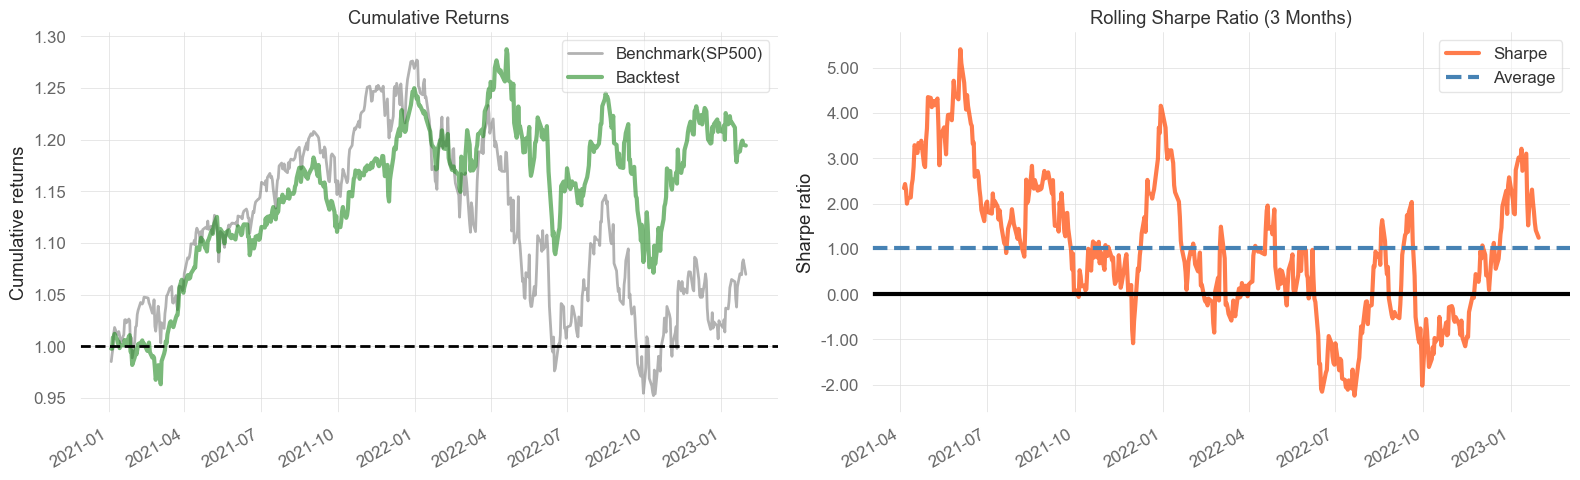

In [41]:
benchmark_return.name='Benchmark(SP500)'
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(daily_return,
                     factor_returns=benchmark_return,
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout()

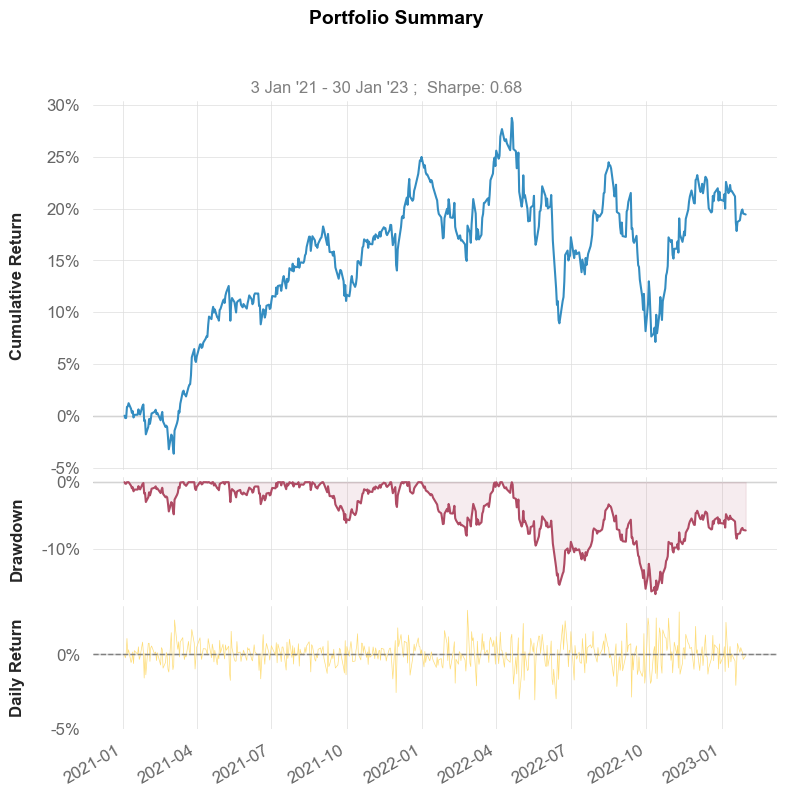

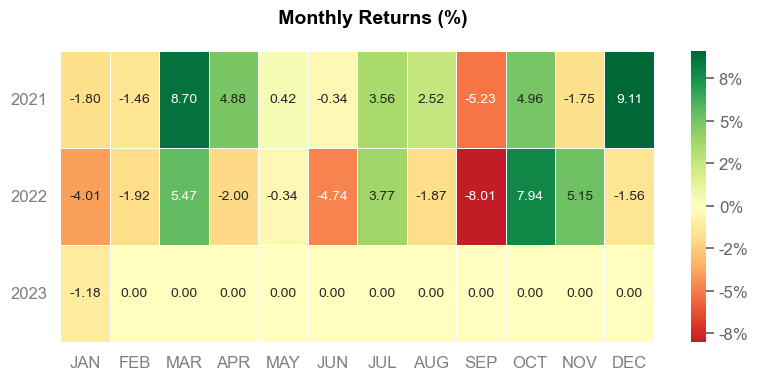

In [42]:
qs.reports.plots(daily_return, mode='basic')

In [43]:
qs.reports.metrics(daily_return, benchmark=benchmark_return, mode='basic')

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2021-01-04  2021-01-04
End Period          2023-01-30  2023-01-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   19.43%      6.97%
CAGR﹪              8.95%       3.31%

Sharpe              0.68        0.26
Prob. Sharpe Ratio  83.63%      64.81%
Sortino             0.97        0.37
Sortino/√2          0.69        0.26
Omega               1.12        1.12

Max Drawdown        -16.8%      -25.43%
Longest DD Days     284         391

Gain/Pain Ratio     0.12        0.05
Gain/Pain (1M)      0.55        0.2

Payoff Ratio        0.92        0.97
Profit Factor       1.12        1.05
Common Sense Ratio  1.13        1.02
CPC Index           0.57        0.51
Tail Ratio          1.01        0.98
Outlier Win Ratio   3.99        2.71
Outlier Loss Ratio  3.9         3.09

MTD                 -1.18%      4.64%
3M                  1.88%       2.99%
